**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- outlier detection/removal,
- matrix profile.

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.signal import butter, sosfilt
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    from numpy.lib.stride_tricks import sliding_window_view  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]

except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )

In [3]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

In [4]:
def fill_band(array2D: np.ndarray, width: int = 1, value=0) -> np.ndarray:
    """Fill thick diagonal band of a matrix with value"""
    n_rows, n_cols = array2D.shape
    distance_from_diag = np.abs(np.add.outer(np.arange(n_rows), -np.arange(n_cols)))
    array2D[distance_from_diag <= width] = value
    return array2D

## Outliers detection/removal

In [5]:
X, _, description = load_nyc_taxi_dataset()

print(description)

This data set contains the number of New York taxi passengers aggregated in 30 minutes buckets for the period between July 2014 and January 2015. There are five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

The raw data is from the NYC Taxi and Limousine Commission [1] and has been curated by [2].

[1]: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 
[2]: Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing.


In [6]:
original_calendar_time_array = X.timestamp.to_numpy()
original_taxi_count_np = X.taxi_count.to_numpy()

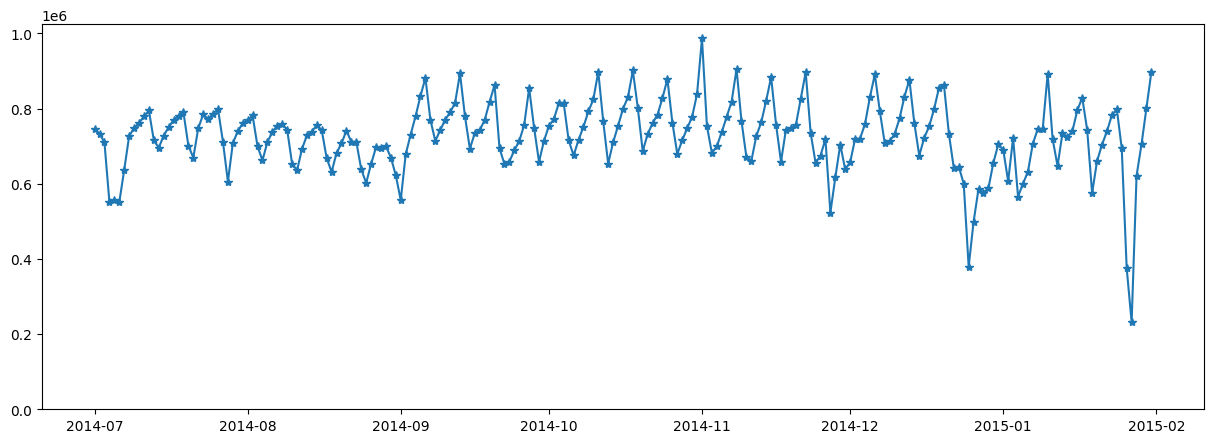

In [7]:
daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
calendar_time_array = daily_taxi_count.index.to_numpy()
n_samples = daily_taxi_count_np.size
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

### Distribution

On the original data.

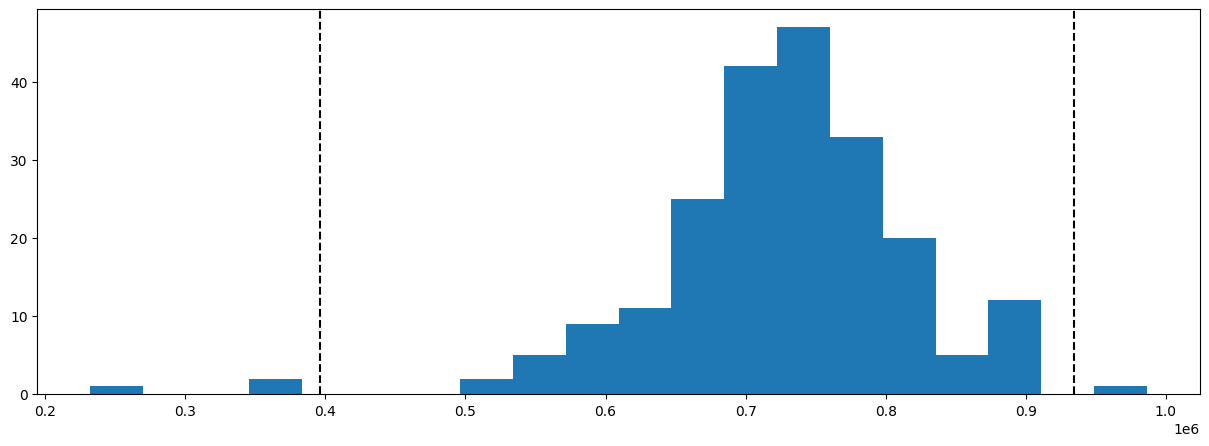

In [8]:
quantile_threshold_low, quantile_threshold_high = 0.01, 0.997

fig, ax = fig_ax()
_ = ax.hist(daily_taxi_count_np, 20)

threshold_low, threshold_high = np.quantile(
    daily_taxi_count_np, [quantile_threshold_low, quantile_threshold_high]
)

_ = ax.axvline(threshold_low, ls="--", color="k")
_ = ax.axvline(threshold_high, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous cell, modify <tt>quantile_threshold_low</tt> and <tt>quantile_threshold_high</tt> to only exclude outliers.</p>
</div>

Plot the outliers directly on the signal.

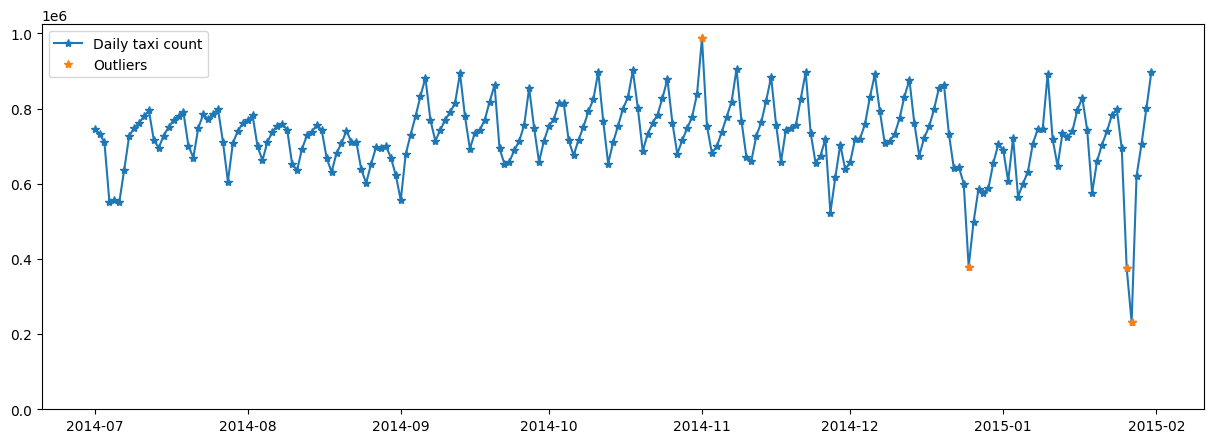

In [9]:
fig, ax = fig_ax()
ax.plot(calendar_time_array, daily_taxi_count_np, "*-", label="Daily taxi count")

outlier_mask = (daily_taxi_count_np < threshold_low) | (
    daily_taxi_count_np > threshold_high
)

ax.plot(
    calendar_time_array[outlier_mask],
    daily_taxi_count_np[outlier_mask],
    "*",
    label="Outliers",
)

plt.legend()
_ = ax.set_ylim(0)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Repeat the same procedure on the distribution of the previous seasonal fit.</p>
</div>

This method can be extended for any type of signal approximation (SSA, polynomial, smoothing, etc.)

### Matrix profile

Informally, an outlier is a motif that only appears once a signal.
The distance of this particular pattern from all other patterns is large.

Algorithmically:

- Extract the trajectory matrix.
- Compute the pairwise distances between all patterns.
- Set to Inf the distance between patterns that overlap.
- Take the minimum pairwise distance for each pattern (the profile)


Then we apply outlier detection on the profile.

In [10]:
window_shape = 7
quantile_threshold_high = 0.9

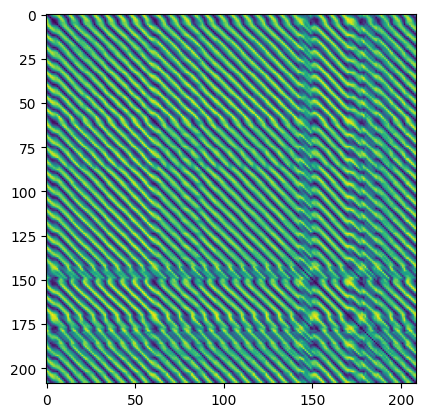

In [12]:
# extract the trajectory matrix
trajectory_matrix = get_trajectory_matrix(
    arr=daily_taxi_count_np, window_shape=window_shape
)

# compute distance matrix
distance_matrix = squareform(pdist(trajectory_matrix, metric="correlation"))
plt.imshow(distance_matrix);

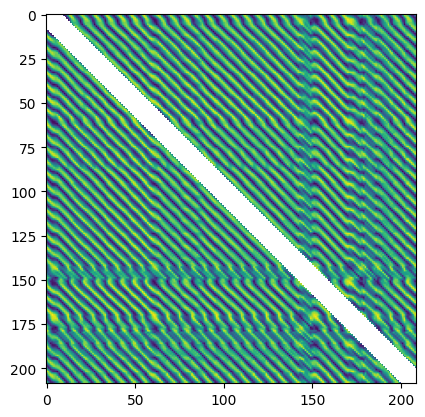

In [14]:
# set to inf the overlapping windows
distance_matrix = fill_band(distance_matrix, window_shape, np.inf)
plt.imshow(distance_matrix);

In [15]:
# compute profile
profile = distance_matrix.min(axis=1)

We can now do outlier detection on the profile

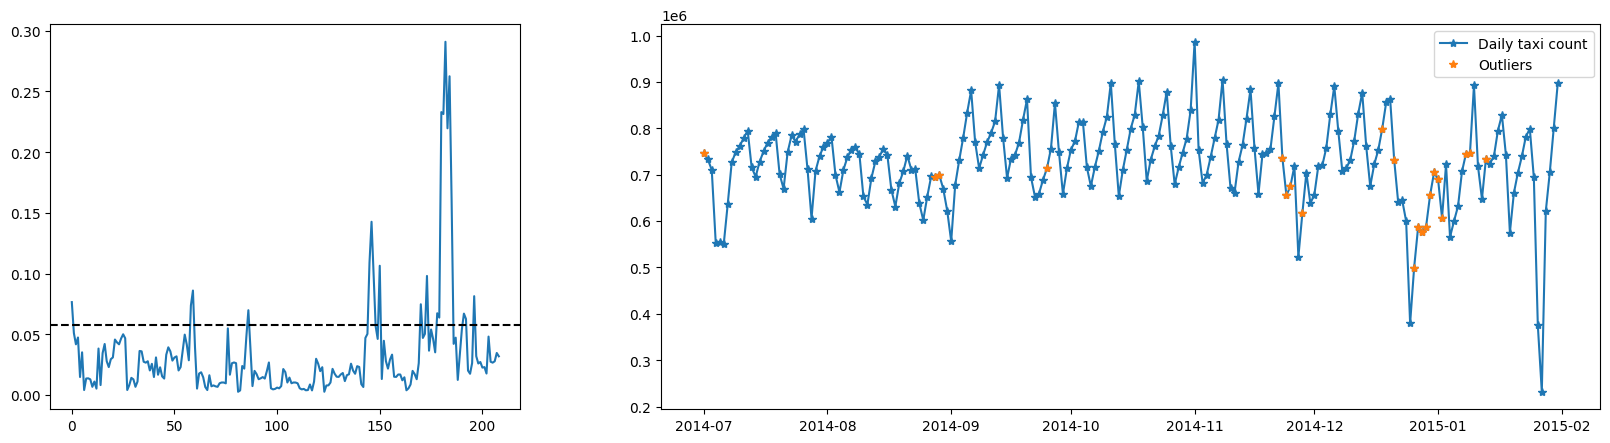

In [16]:
# get threshold
threshold_high = np.quantile(profile, quantile_threshold_high)


# plot results
fig, (ax_0, ax_1) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1, 2]}, figsize=(20, 5)
)

ax_0.plot(profile)
ax_0.axhline(threshold_high, ls="--", color="k")

ax_1.plot(calendar_time_array, daily_taxi_count_np, "*-", label="Daily taxi count")
outlier_mask = profile > threshold_high
offset = window_shape - 1
ax_1.plot(
    calendar_time_array[:-offset][outlier_mask],
    daily_taxi_count_np[:-offset][outlier_mask],
    "*",
    label="Outliers",
)
_ = plt.legend()

Un inconvénient du matrix profile est qu'il ne permet pas de détecter deux anomalies identiques.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Repeat the same experiment on the original (not daily) signal for windows of one day, two days and a week. 
    Report the dates that you find interesting.</p>
</div>